# Day 52 - 神经网络调参指南

本教程将系统介绍神经网络中的关键调参技术，帮助你理解和掌握模型训练的核心概念。

## 目录
1. [随机种子](#1-随机种子)
2. [权重初始化](#2-权重初始化)
3. [学习率调度](#3-学习率调度)
4. [正则化策略](#4-正则化策略)
5. [早停策略](#5-早停策略)

---

## 1. 随机种子

### 1.1 为什么需要随机种子？

在深度学习中，存在多个随机性来源：

| 来源 | 说明 |
|-----|-----|
| 权重初始化 | 权重和偏置的随机初始值 |
| 数据加载 | Shuffle打乱、随机批次加载 |
| 数据增强 | 随机旋转、缩放、平移、裁剪等 |
| Dropout | 随机正则化 |
| 优化器 | 某些优化器的随机性 |

设置随机种子可以确保**实验可重复性**，让每次训练得到相同的结果。

In [1]:
import torch
import torch.nn as nn

# 定义一个简单的线性模型
# 输入2个维度，输出1个维度
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # 线性层：y = w1*x1 + w2*x2 + b
        self.linear = nn.Linear(2, 1)
        
    def forward(self, x):
        return self.linear(x)

# 创建模型实例（每次运行权重不同）
model = SimpleNet()

# 查看模型参数
print("模型参数（未设置种子，每次运行可能不同）:")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

模型参数（未设置种子，每次运行可能不同）:
linear.weight: tensor([[0.4258, 0.4165]])
linear.bias: tensor([0.1695])


### 1.2 设置全局随机种子

以下函数可以设置所有常见的随机种子，确保实验可重复：

In [2]:
import torch
import numpy as np
import os
import random

def set_seed(seed=42, deterministic=True):
    """
    设置全局随机种子，确保实验可重复性
    
    Args:
        seed: 随机种子值，默认为42
        deterministic: 是否启用确定性模式，默认为True
    """
    # 1. Python内置random模块
    random.seed(seed)
    
    # 2. 环境变量（确保哈希函数一致性）
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # 3. NumPy随机种子
    np.random.seed(seed)
    
    # 4. PyTorch CPU随机种子
    torch.manual_seed(seed)
    
    # 5. PyTorch GPU随机种子
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 多GPU情况
    
    # 6. cuDNN确定性配置
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 设置随机种子
set_seed(42)

# 验证效果：现在每次运行结果相同
model = SimpleNet()
print("模型参数（设置种子后，每次运行相同）:")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

模型参数（设置种子后，每次运行相同）:
linear.weight: tensor([[0.5406, 0.5869]])
linear.bias: tensor([-0.1657])


---

## 2. 权重初始化

### 2.1 为什么权重初始化很重要？

神经网络权重的初始值会直接影响训练效果：

**问题1：对称性问题**
- 如果所有权重相同（包括全0），同一层的所有神经元输出相同
- 反向传播时梯度也相同，导致无法学习不同特征

**问题2：梯度消失/爆炸**
- 权重过小 → 信号逐层衰减 → 梯度消失
- 权重过大 → 信号逐层放大 → 梯度爆炸

In [3]:
import torch
import torch.nn as nn

# 演示梯度消失问题
def demo_gradient_problem():
    """展示权重初始化对梯度的影响"""
    
    # 定义深层网络
    class DeepNet(nn.Module):
        def __init__(self, init_scale):
            super().__init__()
            layers = []
            for _ in range(10):  # 10层网络
                linear = nn.Linear(100, 100, bias=False)
                # 使用指定的初始化尺度
                nn.init.normal_(linear.weight, mean=0, std=init_scale)
                layers.append(linear)
                layers.append(nn.Tanh())
            self.net = nn.Sequential(*layers)
            
        def forward(self, x):
            return self.net(x)
    
    # 测试不同初始化尺度
    for scale in [0.01, 0.1, 1.0]:
        model = DeepNet(scale)
        x = torch.randn(1, 100)
        output = model(x)
        print(f"初始化std={scale}: 输出均值={output.mean().item():.6f}, 输出std={output.std().item():.6f}")

demo_gradient_problem()

初始化std=0.01: 输出均值=-0.000000, 输出std=0.000000
初始化std=0.1: 输出均值=-0.003439, 输出std=0.158675
初始化std=1.0: 输出均值=-0.104992, 输出std=0.953832


### 2.2 常见初始化方法

| 方法 | 公式 | 适用场景 |
|-----|------|--------|
| 零初始化 | W = 0 | ❌ 不推荐（对称性问题） |
| 随机初始化 | W ~ N(0, 0.01) | 浅层网络 |
| Xavier/Glorot | W ~ N(0, √(2/(n_in+n_out))) | Sigmoid/Tanh |
| He/Kaiming | W ~ N(0, √(2/n_in)) | ReLU |

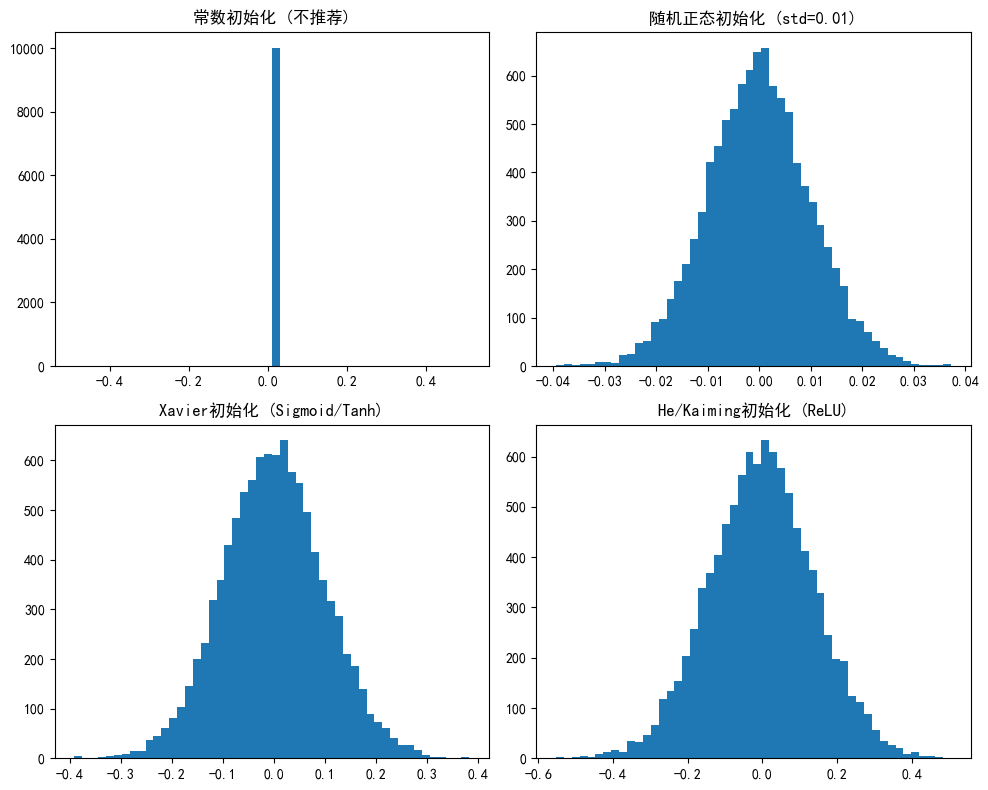

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 演示不同初始化方法
def compare_init_methods():
    """比较不同初始化方法的权重分布"""
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    
    # 1. 常数初始化（不推荐）
    layer1 = nn.Linear(100, 100)
    nn.init.constant_(layer1.weight, 0.01)
    axes[0].hist(layer1.weight.data.numpy().flatten(), bins=50)
    axes[0].set_title('常数初始化 (不推荐)')
    
    # 2. 随机正态初始化
    layer2 = nn.Linear(100, 100)
    nn.init.normal_(layer2.weight, mean=0, std=0.01)
    axes[1].hist(layer2.weight.data.numpy().flatten(), bins=50)
    axes[1].set_title('随机正态初始化 (std=0.01)')
    
    # 3. Xavier初始化（适用于Sigmoid/Tanh）
    layer3 = nn.Linear(100, 100)
    nn.init.xavier_normal_(layer3.weight)
    axes[2].hist(layer3.weight.data.numpy().flatten(), bins=50)
    axes[2].set_title('Xavier初始化 (Sigmoid/Tanh)')
    
    # 4. He初始化（适用于ReLU）
    layer4 = nn.Linear(100, 100)
    nn.init.kaiming_normal_(layer4.weight, mode='fan_in', nonlinearity='relu')
    axes[3].hist(layer4.weight.data.numpy().flatten(), bins=50)
    axes[3].set_title('He/Kaiming初始化 (ReLU)')
    
    plt.tight_layout()
    plt.show()

compare_init_methods()

### 2.3 自定义初始化函数

In [5]:
import torch.nn as nn

def init_weights(model, init_type='kaiming'):
    """
    自定义权重初始化函数
    
    Args:
        model: PyTorch模型
        init_type: 初始化类型 ('xavier', 'kaiming', 'normal')
    """
    for name, param in model.named_parameters():
        if 'weight' in name:
            if init_type == 'xavier':
                nn.init.xavier_normal_(param)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='relu')
            elif init_type == 'normal':
                nn.init.normal_(param, mean=0, std=0.01)
        elif 'bias' in name:
            nn.init.constant_(param, 0)
    return model

# 使用示例
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = MLP()
model = init_weights(model, 'kaiming')
print("使用Kaiming初始化后的模型权重统计:")
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"{name}: mean={param.mean():.4f}, std={param.std():.4f}")

使用Kaiming初始化后的模型权重统计:
fc1.weight: mean=-0.0001, std=0.0504
fc2.weight: mean=0.0000, std=0.0866


---

## 3. 学习率调度

### 3.1 学习率的重要性

学习率是最重要的超参数之一：

| 学习率 | 问题 |
|-------|------|
| 过大 | 震荡、无法收敛、跳过最优解 |
| 过小 | 收敛慢、容易陷入局部最优 |

**最佳实践**：初期使用较大学习率快速探索，后期逐渐减小以精细调整。

/home/ubuntu24/anaconda3/envs/torch-gpu/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


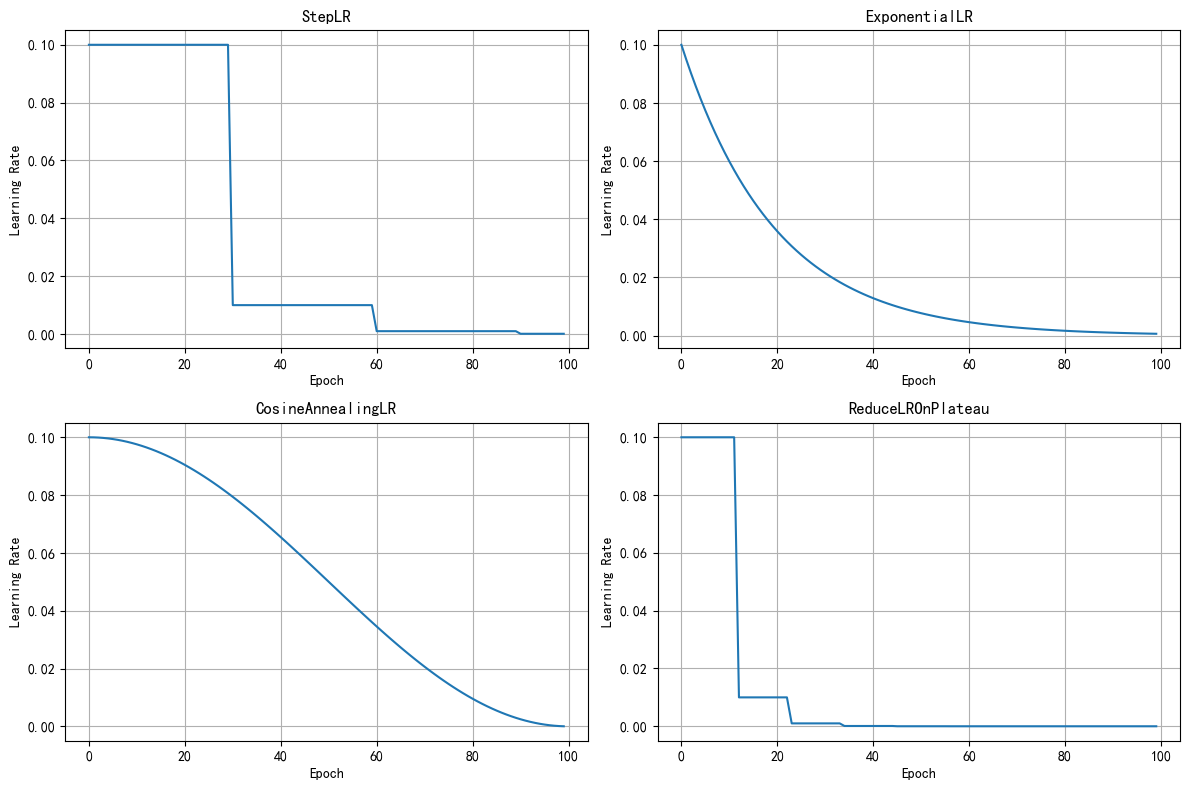

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 演示不同学习率调度器
def demo_lr_schedulers():
    """展示不同学习率调度器的效果"""
    
    epochs = 100
    initial_lr = 0.1
    
    schedulers = {
        'StepLR': lambda opt: optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1),
        'ExponentialLR': lambda opt: optim.lr_scheduler.ExponentialLR(opt, gamma=0.95),
        'CosineAnnealingLR': lambda opt: optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100),
        'ReduceLROnPlateau': lambda opt: optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=10)
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for idx, (name, scheduler_fn) in enumerate(schedulers.items()):
        # 创建简单模型和优化器
        model = nn.Linear(10, 1)
        optimizer = optim.SGD(model.parameters(), lr=initial_lr)
        scheduler = scheduler_fn(optimizer)
        
        lrs = []
        for epoch in range(epochs):
            lrs.append(optimizer.param_groups[0]['lr'])
            if name == 'ReduceLROnPlateau':
                scheduler.step(1.0)  # 需要传入loss值
            else:
                scheduler.step()
        
        axes[idx].plot(lrs)
        axes[idx].set_title(name)
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel('Learning Rate')
        axes[idx].grid(True)
    
    plt.tight_layout()
    plt.show()

demo_lr_schedulers()

### 3.2 常用学习率调度器总结

| 调度器 | 特点 | 适用场景 |
|-------|------|--------|
| StepLR | 每隔固定epoch降低lr | 通用 |
| ExponentialLR | 指数衰减 | 需要平滑下降 |
| CosineAnnealingLR | 余弦退火 | 配合warmup |
| ReduceLROnPlateau | 根据指标自适应调整 | 验证集性能监控 |

---

## 4. 正则化策略

正则化用于**防止过拟合**，提高模型泛化能力。

### 4.1 L1/L2正则化

| 类型 | 公式 | 效果 |
|-----|------|------|
| L1 | λ∑|w| | 稀疏权重（特征选择） |
| L2 | λ∑w² | 权重衰减（更平滑） |

In [7]:
import torch.optim as optim

# L2正则化（权重衰减）在PyTorch中通过weight_decay参数实现
model = nn.Linear(100, 10)

# 创建带L2正则化的优化器
optimizer = optim.Adam(
    model.parameters(), 
    lr=0.001, 
    weight_decay=1e-4  # L2正则化系数
)

print(f"优化器配置: {optimizer}")
print(f"L2正则化系数: {optimizer.param_groups[0]['weight_decay']}")

优化器配置: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
L2正则化系数: 0.0001


### 4.2 Dropout

Dropout在训练时**随机丢弃**部分神经元，迫使网络学习更鲁棒的特征。

**注意**：测试时需要关闭Dropout（调用`model.eval()`）

In [8]:
import torch
import torch.nn as nn

class MLPWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout层
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # 训练时随机丢弃50%神经元
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

# 演示训练/测试模式的区别
model = MLPWithDropout(dropout_rate=0.5)
x = torch.randn(1, 784)

# 训练模式
model.train()
out1 = model(x)
out2 = model(x)
print(f"训练模式 - 两次输出是否相同: {torch.allclose(out1, out2)}")

# 测试模式（关闭Dropout）
model.eval()
out3 = model(x)
out4 = model(x)
print(f"测试模式 - 两次输出是否相同: {torch.allclose(out3, out4)}")

训练模式 - 两次输出是否相同: False
测试模式 - 两次输出是否相同: True


---

## 5. 早停策略

### 5.1 什么是早停？

早停（Early Stopping）是一种防止过拟合的技术：
- 监控验证集性能
- 当性能不再提升时停止训练
- 保存最佳模型参数

In [9]:
class EarlyStopping:
    """
    早停类：监控验证集性能，在性能不再提升时停止训练
    """
    def __init__(self, patience=7, min_delta=0, verbose=True):
        """
        Args:
            patience: 允许多少个epoch性能不提升
            min_delta: 性能提升的最小阈值
            verbose: 是否打印信息
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, val_loss, model):
        score = -val_loss  # 转换为越大越好
        
        if self.best_score is None:
            # 第一次调用
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            # 性能没有提升
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # 性能提升
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        """保存模型状态"""
        self.best_model_state = model.state_dict().copy()
        if self.verbose:
            print(f'验证损失下降，保存模型...')
            
    def load_best_model(self, model):
        """加载最佳模型"""
        model.load_state_dict(self.best_model_state)
        return model

# 使用示例
print("早停策略使用示例:")
print("""
early_stopping = EarlyStopping(patience=7)

for epoch in range(epochs):
    train_loss = train(model, train_loader)
    val_loss = validate(model, val_loader)
    
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# 加载最佳模型
model = early_stopping.load_best_model(model)
""")

早停策略使用示例:

early_stopping = EarlyStopping(patience=7)

for epoch in range(epochs):
    train_loss = train(model, train_loader)
    val_loss = validate(model, val_loader)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# 加载最佳模型
model = early_stopping.load_best_model(model)



---

## 总结

本教程介绍了神经网络调参的5个关键技术：

| 技术 | 作用 | 关键点 |
|-----|------|-------|
| **随机种子** | 实验可重复性 | 设置Python/NumPy/PyTorch/cuDNN种子 |
| **权重初始化** | 避免梯度问题 | Xavier(Sigmoid/Tanh), He(ReLU) |
| **学习率调度** | 平衡收敛速度和精度 | 余弦退火、分段衰减 |
| **正则化** | 防止过拟合 | L2正则化、Dropout |
| **早停** | 防止过拟合 | 监控验证集，保存最佳模型 |

### 推荐的调参顺序

1. 设置随机种子
2. 选择合适的权重初始化
3. 调整学习率和调度器
4. 添加正则化
5. 配置早停